# Volatility smile

## Recall BSM formula

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import scipy.optimize as so

In [2]:
'''============
Gbm class inherited from sde_1d
Usage:
    gbm1 = Gbm(init_state = 100., drift_ratio=.05, vol_ratio=.2)
============='''

class Gbm:
    def __init__(self,
                 init_state = 100.,
                 drift_ratio = .0475,
                 vol_ratio = .2
                ):
        self.init_state = init_state
        self.drift_ratio = drift_ratio
        self.vol_ratio = vol_ratio
        
        

In [3]:
'''=========
option class init
Usage:
    option1 = EuropeanOption(otype = 1, strike = 100., maturity = 1/12)
=========='''
class EuropeanOption:
    def __init__(self,
                otype = 1, # 1: 'call'
                        # -1: 'put'
                strike = 110.,
                maturity = 1.
                ):
        self.otype = otype
        self.strike = strike
        self.maturity = maturity
        
    def payoff(self, s): #s: excercise price
        otype = self.otype
        k = self.strike
        maturity = self.maturity
        return np.max([0, (s - k)*otype])
        

In [4]:
'''========
Black-Scholes-Merton formula. 
=========='''

def bsm_price(self, european_option):
    s0 = self.init_state
    sigma = self.vol_ratio
    r = self.drift_ratio
    
    otype = european_option.otype
    k = european_option.strike
    maturity = european_option.maturity
    
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) 
          * maturity) / (sigma * np.sqrt(maturity))
    d2 = d1 - sigma * np.sqrt(maturity)
    
    return otype * s0 * ss.norm.cdf(otype * d1) - otype * np.exp(-r * maturity) * k * ss.norm.cdf(otype * d2)

Gbm.bsm_price = bsm_price

In [5]:
'''===============
Test bsm_price
================='''
gbm1 = Gbm()
option1 = EuropeanOption()
print('--->>call value is ' + str(gbm1.bsm_price(option1)))
option2 = EuropeanOption(otype=-1)
print('--->>put value is ' + str(gbm1.bsm_price(option2)))


--->>call value is 5.943273183452838
--->>put value is 10.84042522804176


## Implied volatility

In the market, usually volatility (vol = 0.2 in the above) is not available, but market price (call = 5.94) for the option is available. One wants find a volatility such that associated BSM formula is equal to (fit) the market price. 

In [6]:
'''==========
define a method to seek for an implied volatility
============'''

def implied_volatility(spot_price, otype, maturity, strike, interest_rate, market_option_price):
    option = EuropeanOption(otype, strike, maturity)
    init_vol = .1 #initial guess
    gbm = Gbm(spot_price, interest_rate, init_vol)
    
    def error_function(vol):
        gbm.vol_ratio = vol
        return np.abs(market_option_price - gbm.bsm_price(option))
    
    return so.fmin(error_function, 0.1, disp = False)[0]

In [7]:
'''============
test the implied_vol by reversing bsm_formula example in the above
=============='''
print('---->>>>implied volatility is')
implied_volatility(spot_price=100, otype=1, maturity=1, strike=110, interest_rate=.0475, market_option_price=5.94)

---->>>>implied volatility is


0.19992187500000036

## Volatility smile

In [8]:
'''======
Read data
========='''
#Read four-column data
#columns are otype, maturity, strike, option_price
np_option_data1 = np.loadtxt('optiondata1.dat', comments='#', delimiter=',')

print('--->>first a few columns are <<-----')
print('otype, maturity, strike, option_price')
for i in range(5):
    print(np_option_data1[i, :])

--->>first a few columns are <<-----
otype, maturity, strike, option_price
[-1.00000000e+00  8.33333333e-02  9.60000000e+01  7.41326933e-01]
[-1.00000000e+00  8.33333333e-02  9.70000000e+01  9.96604515e-01]
[-1.00000000e+00  8.33333333e-02  9.80000000e+01  1.44455929e+00]
[-1.00000000e+00  8.33333333e-02  9.90000000e+01  1.66917359e+00]
[-1.00000000e+00  8.33333333e-02  1.00000000e+02  2.15410806e+00]


In [9]:
#below are given 
spot_price = 100
interest_rate = .05

num_row = np_option_data1.shape[0]
#expand one column for vol
np_option_data2 = np.c_[np_option_data1, np.zeros([num_row, 1])]

#compute implied vol
for i in range(num_row):
    otype = np_option_data1[i, 0]
    maturity = np_option_data1[i,1]
    strike = np_option_data1[i,2]
    market_option_price = np_option_data1[i,3]
    
    np_option_data2[i, 4] = implied_volatility(spot_price, otype, maturity, strike, interest_rate, market_option_price)
    

for i in range(5):
    print(np_option_data2[i, :])

[-1.00000000e+00  8.33333333e-02  9.60000000e+01  7.41326933e-01
  2.04492188e-01]
[-1.00000000e+00  8.33333333e-02  9.70000000e+01  9.96604515e-01
  2.04140625e-01]
[-1.00000000e+00  8.33333333e-02  9.80000000e+01  1.44455929e+00
  2.16562500e-01]
[-1.00000000e+00  8.33333333e-02  9.90000000e+01  1.66917359e+00
  2.01757813e-01]
[-1.00000000e+00  8.33333333e-02  1.00000000e+02  2.15410806e+00
  2.05039063e-01]


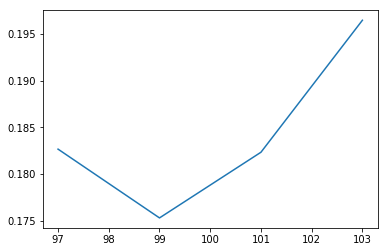

In [23]:
filter1 = np_option_data2[np_option_data2[:,1] == 2/12]
filter2 = filter1[filter1[:,0] == 1.]
filter3 = filter2[filter2[:,2].astype(int)%2 == 1]
plt.plot(filter3[:,2], filter3[:,4])

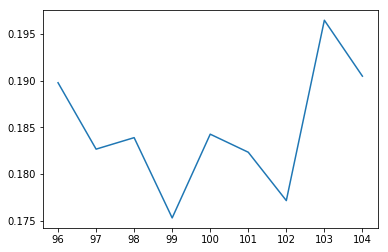

In [24]:
filter1 = np_option_data2[np_option_data2[:,1] == 2/12]
filter2 = filter1[filter1[:,0] == 1.]
plt.plot(filter2[:,2], filter2[:,4])

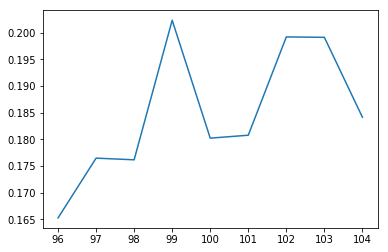

In [12]:
filter1 = np_option_data2[np_option_data2[:,1] == 1/12]
filter2 = filter1[filter1[:,0] == 1.]
plt.plot(filter2[:,2], filter2[:,4])

In [13]:
'''==========
volatility is nearly zero
============='''
filter2

array([[1.00000000e+00, 8.33333333e-02, 9.60000000e+01, 4.83197800e+00,
        1.65273438e-01],
       [1.00000000e+00, 8.33333333e-02, 9.70000000e+01, 4.14344982e+00,
        1.76484375e-01],
       [1.00000000e+00, 8.33333333e-02, 9.80000000e+01, 3.43375951e+00,
        1.76171875e-01],
       [1.00000000e+00, 8.33333333e-02, 9.90000000e+01, 3.08791942e+00,
        2.02343750e-01],
       [1.00000000e+00, 8.33333333e-02, 1.00000000e+02, 2.28560467e+00,
        1.80234375e-01],
       [1.00000000e+00, 8.33333333e-02, 1.01000000e+02, 1.81044287e+00,
        1.80781250e-01],
       [1.00000000e+00, 8.33333333e-02, 1.02000000e+02, 1.60882709e+00,
        1.99218750e-01],
       [1.00000000e+00, 8.33333333e-02, 1.03000000e+02, 1.25953601e+00,
        1.99140625e-01],
       [1.00000000e+00, 8.33333333e-02, 1.04000000e+02, 8.27376063e-01,
        1.84160156e-01]])